In [1]:
!pip install scikit-image
!pip install ipywidgets
!pip install langchain
!pip install gtts
!pip install langchain
!pip install -U boto3
!pip install botocore
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached pillow-10.4.0-cp311-cp311-macosx_10_10_x86_64.whl.metadata (9.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 1.7 MB/s eta 0:00:0000:0100:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.2/21.2 MB 5.0 MB/s eta 0:00:0000:0100:01
Using cached pillow-10.4.0-cp311-cp311-macosx_10_10_x86_64.whl (3.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 kB 3.4 MB/s eta 0:00:00a 0:00:0

In [2]:
#list of imports

import boto3
import json
from langchain import PromptTemplate
from gtts import gTTS
import os
from IPython.display import display
import ipywidgets as widgets
from skimage import io

In [3]:
!pip show boto3

Name: boto3
Version: 1.34.149
Summary: The AWS SDK for Python
Home-page: https://github.com/boto/boto3
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /opt/anaconda3/envs/myenv/lib/python3.11/site-packages
Requires: botocore, jmespath, s3transfer
Required-by: 


In [4]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime', 
    region_name='us-east-1'
)

In [5]:
llm_type = 'titan'

In [21]:
def interactWithLLM(prompt,llm_type):

	if llm_type == 'titan':
		print("**THE LLM TYPE IS -->" + llm_type)
		#Test for invoke model begins
		parameters = {
			"maxTokenCount":512,
			"stopSequences":[],
			"temperature":0,
			"topP":0.9
		}
		body = json.dumps({"inputText": prompt, "textGenerationConfig": parameters})
		modelId = "amazon.titan-text-lite-v1" #"amazon.titan-tg1-large"
		accept = "application/json"
		contentType = "application/json"

		response = bedrock_client.invoke_model(
			body=body, modelId=modelId, accept=accept, contentType=contentType
		)

		response_body = json.loads(response.get("body").read())

		print(response_body)

		response_text_titan = response_body.get("results")[0].get("outputText")

		return response_text_titan

In [22]:
region = "us-east-1"

def imageAnalyzer(input_img):
    
    rek_client = boto3.client('rekognition', region_name=region)

    print(input_img)
    with open(input_img, 'rb') as image:
        response = rek_client.detect_labels(Image={'Bytes': image.read()})

    labels = response['Labels']
    print(f'Found {len(labels)} labels in the image:')
    label_names = ''
    for label in labels:
        name = label['Name']
        confidence = label['Confidence']
        #print(f'> Label "{name}" with confidence {confidence:.2f}')
        if confidence>85:
            print(name + "|" + str(confidence))
            label_names = label_names + name + ","

    return label_names

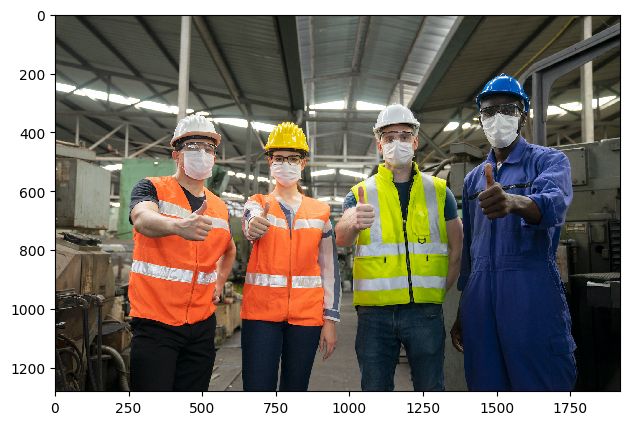

In [23]:
input_img = 'ppe_group_updated.jpg'
img = io.imread(input_img)
io.imshow(img)

In [24]:
label_names = imageAnalyzer(input_img)

ppe_group_updated.jpg
Found 13 labels in the image:
Person|100.0
Worker|100.0
Clothing|99.99998474121094
Hardhat|99.99998474121094
Helmet|99.99998474121094
Adult|98.31578063964844
Male|98.31578063964844
Man|98.31578063964844
Female|96.79420471191406
Woman|96.79420471191406


In [25]:
prompt_claude = """
Human:  Here are the comma seperated list of labels/objects seen in the image:
<labels>
{labels}
</labels>
Please provide a human readible and Understandable summary based on these labels
Assistant:
"""

In [27]:
prompt_template_for_summary_generate = PromptTemplate.from_template(prompt_claude)
prompt_data_for_summary_generate = prompt_template_for_summary_generate.format(labels=label_names)
# print("prompt_data_for_summary_generate : ->" + prompt_data_for_summary_generate)

print(prompt_data_for_summary_generate, "HAHAHAHAHA")

response_text = interactWithLLM(prompt_data_for_summary_generate,llm_type)
# print('response_text --- \n' + response_text)


Human:  Here are the comma seperated list of labels/objects seen in the image:
<labels>
Person,Worker,Clothing,Hardhat,Helmet,Adult,Male,Man,Female,Woman,
</labels>
Please provide a human readible and Understandable summary based on these labels
Assistant:
 HAHAHAHAHA
**THE LLM TYPE IS -->titan
{'inputTextTokenCount': 73, 'results': [{'tokenCount': 38, 'outputText': 'The image shows a group of people wearing various clothing and safety gear, including hard hats, helmets, and safety vests. The people are divided into two groups: adults and children.', 'completionReason': 'FINISH'}]}
